# Experiment  0: ToM Overall Model Performance


In [1]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch

In [2]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [3]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [4]:
def visualize_map(campus,
                  path=None,
                  goal_nodes=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if goal_nodes:
        goal_coords = [campus.node_coords[n] for n in goal_nodes]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Goal")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

In [5]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color


## Steps  
1. Create the UCSD campus world
2. Create n agents each with a specific distribution over the goals
3. Run m epsiodes where each agent chooses a goal and performs a single path to that goal
4. Use this data as training set

## Step 1: Create the Map

In [6]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Started new simulation run #38
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_38_20250507_114804
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges


## Step 2: Create N Agents

In [7]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [8]:
# Create n agents
agents = []
n = 100
for i in range(n):
    agents.append(AgentFactory.create_agent("shortest"))
    agents[i].id = i

In [9]:
n_goals = len(goals)
ag_alpha = np.random.normal(1, 0.2, size=n_goals)

for agent in agents: # Set each agent's goal distribution
    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]
    agent.environment = campus

In [10]:
def new_episode(agents):

    # Set the goal and start nodes
    for agent in agents:
        agent.path = [] # Clear the old path
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])

        while True:
            start_node = campus.get_random_node()
            try:
                path = nx.shortest_path(campus.G_undirected, 
                                       source=start_node, 
                                       target=agent.goal_node, 
                                       weight='length')
                if len(path) >15:  # Make sure path is non-trivial
                    break
            except:
                continue
        agent.start_node = start_node
        agent.current_node = start_node

    return 

In [11]:
# Save the agents 
import pickle

# suppose `agents` is your list of Agent instances
with open('agents.pkl', 'wb') as f:
    pickle.dump(agents, f)

## Step 3: Perform Episodes and Data Collection

In [12]:
import json

In [13]:
""" Already ran once. Data is saved in /data"""

path_data = {}
goal_data = {}
m = 100
for episode in range(m):
    new_episode(agents)
    episode_path_data = {}
    episode_goal_data = {}
    for agent in agents:
        agent.plan_path()
        episode_path_data[agent.id] = agent.path
        episode_goal_data[agent.id] = agent.goal_node
    # Save the data from each episode
    path_data[episode] = episode_path_data
    goal_data[episode] = episode_goal_data

with open("./data/path_data.json", "w") as file:
    json.dump(path_data, file, indent=4)

with open("./data/goal_data.json", "w") as file:
    json.dump(goal_data, file, indent=4)



### Load existing data

In [14]:
with open("./data/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/goal_data.json", 'r') as file:
    goal_data = json.load(file)

In [15]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [16]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 4: Fit the Models
There should again be a dict of dict for posteriors. The first key will be for the episode, the second key will be the agent, and the value of this will be a list of dicts for the posteriors. 

### BToM

In [17]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [18]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done


In [19]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

for episode in range(len(goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, path_data[episode][agent.id])
    # Reset the posteriors for new episode
    btom.reset_posteriors()

### Extended BToM

In [20]:
# Import BToM baseline
from real_world_src.models.extended_btom import Extended_BToM

In [21]:
ext_btom = Extended_BToM(campus, agents, goals)

Computing shortest paths...
Done


In [22]:
# Calculate all the posteriors using the first 30 episode
ext_posteriors_data = {}

for episode in range(len(goal_data)):
    ext_posteriors_data[episode] = {}
    for agent in agents:
        ext_posteriors_data[episode][agent.id] = ext_btom.update_agent_posterior_over_path(agent, path_data[episode][agent.id])



### ToMNet

In [38]:
from real_world_src.utils.trajectory_collector import TrajectoryCollector
from real_world_src.models.tomnet import ToMNet
from real_world_src.models.tomnet_trainer import ToMNetTrainer
from real_world_src.agents.tom_agent import ToMAgent

In [34]:
trajectory_collector = TrajectoryCollector(campus, max_trajectory_length=1000)
episode_buffers = {}

# Use first 30 episodes for training data
for episode in range(30):
    for agent in agents:
        episode_buffers[agent.id] = []
        goal_node = goal_data[episode][agent.id]
        path = path_data[episode][agent.id]
        for step in path:
            position = campus.get_node_coordinates(step)
            current_node = step
            dist_to_goal = 0
            try:
                dist_to_goal = self.environment.get_path_length([current_node, goal_node])
            except:
                # If path finding fails, use Euclidean distance
                goal_pos = campus.get_node_coordinates(goal_node)
                dist_to_goal = ((position[0] - goal_pos[0])**2 + (position[1] - goal_pos[1])**2) ** 0.5
            
            state = {
                'position': position,
                'node': current_node,
                'goal_node': goal_node,
                'dist_to_goal': dist_to_goal,
                'species': agent.species
            }
            episode_buffers[agent.id].append(state)

    trajectory_collector.finalize_episode(episode_buffers)

In [35]:
# Configure model parameters
input_dim = 5  # State encoding dimension from trajectory_collector
state_dim = 5  # Current state encoding dimension
hidden_dim = 64  # Hidden layer dimension
output_dim = 5  # Prediction output dimension (same as state encoding)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Create and train the model
trainer = ToMNetTrainer(
    input_dim=input_dim,
    state_dim=state_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    lr=0.001,
    device=device
)

Training on: cpu


In [36]:
# Train the model
model = trainer.train(
    trajectory_collector=trajectory_collector,
    batch_size=32,
    epochs=50
)

Starting ToMNet training on cpu...


Training Epoch:   0%|                                                                                  | 0/50 [00:00<?, ?it/s]

Output shape: torch.Size([32, 5, 5])
Target shape: torch.Size([32, 50, 5])
Using first 5 steps for prediction


Training Epoch:   2%|█▍                                                                        | 1/50 [00:06<05:06,  6.25s/it]

Epoch 1/50, Loss: 1.089566


Training Epoch:   4%|██▉                                                                       | 2/50 [00:12<05:03,  6.31s/it]

Epoch 2/50, Loss: 1.000465


Training Epoch:   6%|████▍                                                                     | 3/50 [00:19<04:58,  6.35s/it]

Epoch 3/50, Loss: 0.999772


Training Epoch:   8%|█████▉                                                                    | 4/50 [00:25<04:48,  6.27s/it]

Epoch 4/50, Loss: 0.999730


Training Epoch:  10%|███████▍                                                                  | 5/50 [00:31<04:41,  6.26s/it]

Epoch 5/50, Loss: 0.999808


Training Epoch:  12%|████████▉                                                                 | 6/50 [00:37<04:36,  6.27s/it]

Epoch 6/50, Loss: 0.999648


Training Epoch:  14%|██████████▎                                                               | 7/50 [00:44<04:30,  6.29s/it]

Epoch 7/50, Loss: 0.999389


Training Epoch:  16%|███████████▊                                                              | 8/50 [00:50<04:24,  6.29s/it]

Epoch 8/50, Loss: 0.998514


Training Epoch:  18%|█████████████▎                                                            | 9/50 [00:56<04:16,  6.26s/it]

Epoch 9/50, Loss: 0.996521


Training Epoch:  20%|██████████████▌                                                          | 10/50 [01:02<04:09,  6.25s/it]

Epoch 10/50, Loss: 0.996423


Training Epoch:  22%|████████████████                                                         | 11/50 [01:08<04:03,  6.24s/it]

Epoch 11/50, Loss: 0.995661


Training Epoch:  24%|█████████████████▌                                                       | 12/50 [01:15<03:58,  6.28s/it]

Epoch 12/50, Loss: 0.994980


Training Epoch:  26%|██████████████████▉                                                      | 13/50 [01:21<03:52,  6.30s/it]

Epoch 13/50, Loss: 0.994318


Training Epoch:  28%|████████████████████▍                                                    | 14/50 [01:27<03:46,  6.29s/it]

Epoch 14/50, Loss: 0.993678


Training Epoch:  30%|█████████████████████▉                                                   | 15/50 [01:34<03:38,  6.26s/it]

Epoch 15/50, Loss: 0.993063


Training Epoch:  32%|███████████████████████▎                                                 | 16/50 [01:40<03:32,  6.25s/it]

Epoch 16/50, Loss: 0.992475


Training Epoch:  34%|████████████████████████▊                                                | 17/50 [01:46<03:26,  6.24s/it]

Epoch 17/50, Loss: 0.991916


Training Epoch:  36%|██████████████████████████▎                                              | 18/50 [01:52<03:19,  6.24s/it]

Epoch 18/50, Loss: 0.991387


Training Epoch:  38%|███████████████████████████▋                                             | 19/50 [01:59<03:13,  6.23s/it]

Epoch 19/50, Loss: 0.990888


Training Epoch:  40%|█████████████████████████████▏                                           | 20/50 [02:05<03:07,  6.23s/it]

Epoch 20/50, Loss: 0.990421


Training Epoch:  42%|██████████████████████████████▋                                          | 21/50 [02:11<03:00,  6.24s/it]

Epoch 21/50, Loss: 0.989984


Training Epoch:  44%|████████████████████████████████                                         | 22/50 [02:17<02:54,  6.23s/it]

Epoch 22/50, Loss: 0.989578


Training Epoch:  46%|█████████████████████████████████▌                                       | 23/50 [02:23<02:47,  6.22s/it]

Epoch 23/50, Loss: 0.989202


Training Epoch:  48%|███████████████████████████████████                                      | 24/50 [02:30<02:41,  6.21s/it]

Epoch 24/50, Loss: 0.988855


Training Epoch:  50%|████████████████████████████████████▌                                    | 25/50 [02:36<02:36,  6.27s/it]

Epoch 25/50, Loss: 0.988536


Training Epoch:  52%|█████████████████████████████████████▉                                   | 26/50 [02:42<02:30,  6.28s/it]

Epoch 26/50, Loss: 0.988243


Training Epoch:  54%|███████████████████████████████████████▍                                 | 27/50 [02:49<02:24,  6.29s/it]

Epoch 27/50, Loss: 0.987976


Training Epoch:  56%|████████████████████████████████████████▉                                | 28/50 [02:55<02:18,  6.31s/it]

Epoch 28/50, Loss: 0.987733


Training Epoch:  58%|██████████████████████████████████████████▎                              | 29/50 [03:01<02:12,  6.31s/it]

Epoch 29/50, Loss: 0.987512


Training Epoch:  60%|███████████████████████████████████████████▊                             | 30/50 [03:08<02:05,  6.30s/it]

Epoch 30/50, Loss: 0.987312


Training Epoch:  62%|█████████████████████████████████████████████▎                           | 31/50 [03:14<01:59,  6.28s/it]

Epoch 31/50, Loss: 0.987132


Training Epoch:  64%|██████████████████████████████████████████████▋                          | 32/50 [03:20<01:53,  6.28s/it]

Epoch 32/50, Loss: 0.986970


Training Epoch:  66%|████████████████████████████████████████████████▏                        | 33/50 [03:26<01:46,  6.29s/it]

Epoch 33/50, Loss: 0.986824


Training Epoch:  68%|█████████████████████████████████████████████████▋                       | 34/50 [03:33<01:40,  6.31s/it]

Epoch 34/50, Loss: 0.986694


Training Epoch:  70%|███████████████████████████████████████████████████                      | 35/50 [03:39<01:34,  6.30s/it]

Epoch 35/50, Loss: 0.986577


Training Epoch:  72%|████████████████████████████████████████████████████▌                    | 36/50 [03:45<01:28,  6.31s/it]

Epoch 36/50, Loss: 0.986474


Training Epoch:  74%|██████████████████████████████████████████████████████                   | 37/50 [03:52<01:22,  6.31s/it]

Epoch 37/50, Loss: 0.986381


Training Epoch:  76%|███████████████████████████████████████████████████████▍                 | 38/50 [03:58<01:15,  6.30s/it]

Epoch 38/50, Loss: 0.986299


Training Epoch:  78%|████████████████████████████████████████████████████████▉                | 39/50 [04:04<01:09,  6.31s/it]

Epoch 39/50, Loss: 0.986227


Training Epoch:  80%|██████████████████████████████████████████████████████████▍              | 40/50 [04:11<01:03,  6.33s/it]

Epoch 40/50, Loss: 0.986162


Training Epoch:  82%|███████████████████████████████████████████████████████████▊             | 41/50 [04:17<00:56,  6.31s/it]

Epoch 41/50, Loss: 0.986105


Training Epoch:  84%|█████████████████████████████████████████████████████████████▎           | 42/50 [04:23<00:50,  6.28s/it]

Epoch 42/50, Loss: 0.986055


Training Epoch:  86%|██████████████████████████████████████████████████████████████▊          | 43/50 [04:29<00:43,  6.28s/it]

Epoch 43/50, Loss: 0.986011


Training Epoch:  88%|████████████████████████████████████████████████████████████████▏        | 44/50 [04:36<00:37,  6.29s/it]

Epoch 44/50, Loss: 0.985972


Training Epoch:  90%|█████████████████████████████████████████████████████████████████▋       | 45/50 [04:42<00:31,  6.29s/it]

Epoch 45/50, Loss: 0.985937


Training Epoch:  92%|███████████████████████████████████████████████████████████████████▏     | 46/50 [04:48<00:25,  6.29s/it]

Epoch 46/50, Loss: 0.985907


Training Epoch:  94%|████████████████████████████████████████████████████████████████████▌    | 47/50 [04:55<00:18,  6.27s/it]

Epoch 47/50, Loss: 0.985880


Training Epoch:  96%|██████████████████████████████████████████████████████████████████████   | 48/50 [05:01<00:12,  6.26s/it]

Epoch 48/50, Loss: 0.985857


Training Epoch:  98%|███████████████████████████████████████████████████████████████████████▌ | 49/50 [05:07<00:06,  6.28s/it]

Epoch 49/50, Loss: 0.985836


Training Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 50/50 [05:13<00:00,  6.28s/it]

Epoch 50/50, Loss: 0.985817
Training completed!


In [39]:
tom_agent = ToMAgent(
    agent_id="tom_agent_1",
    environment=campus,
    tomnet=model,
    start_node=None,  # Will be assigned automatically
    goal_node=None,   # Will be assigned automatically
    color="#ffffff"   # White color to distinguish it
)

# Add the ToM agent to the environment
campus.add_agent(tom_agent)

## Step 5: Visualizing Performance for Experiment 0  
We want to visualize the average brier score across all agents for all epsiodes. That is, calculate the brier score for every path and then take the average. Plot this as a line.

In [23]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path

In [24]:
# BToM Scores
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))
# Extended BToM Scores
ext_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        ext_scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  ext_posteriors_data[episode][agent.id], 
                                  goals))

In [25]:
# BToM Scores
btom_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        btom_acc.append(accuracy_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))
# Extended BToM Scores
ext_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        ext_acc.append(accuracy_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  ext_posteriors_data[episode][agent.id], 
                                  goals))

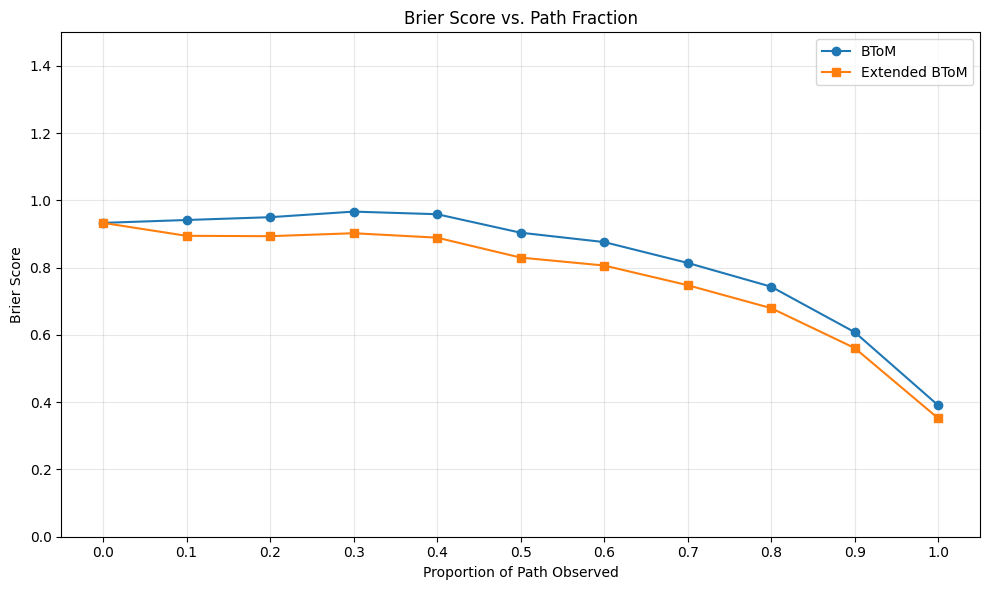

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
ext_arr  = np.array(ext_scores)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1.5)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

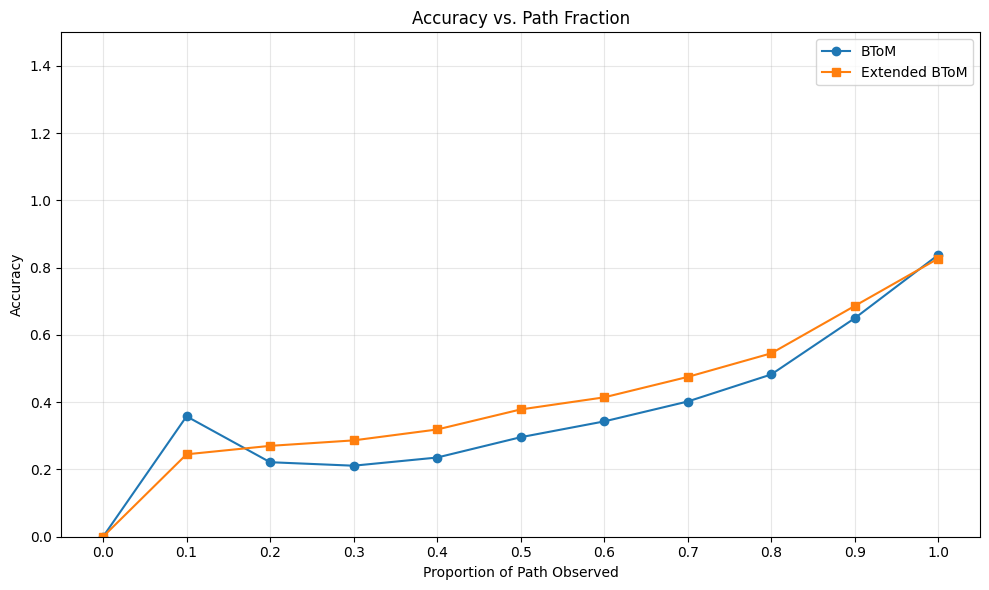

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(btom_acc)  # shape (N, 11)
ext_arr  = np.array(ext_acc)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1.5)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()